# Project Description

**This project aims to apply the task of Sentiment Analysis to the Romanian language. The method proposed uses the pre-trained Bert Base Cased.**

*The dataset used contains product and movie reviews in Romanian and is present in a processed form, as used by the authors of Romanian Transformers in their examples.*

From the existing files in this repository, we will use `train.csv`. 

## Requirement

In [ ]:
!pip install -q -U watermark

Installing the Transformers package from Hugging Face give us a PyTorch interface for working with BERT.

In [ ]:
!pip install -qq transformers

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

We will try to run the algorithm on CUDA if it is available.

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Reading and Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/train.csv")
df.head()

,index,text,label
0,0,acest document mi-a deschis cu adevarat ochii ...,1
1,1,tine mancarea rece. ce altceva ii mai trebuie?...,1
2,2,excelent\nrecomand!,1
3,3,"ca un rocker imbatranit, acest film mentioneaz...",1
4,4,"ei bine, a facut o groaza veche si foarte intu...",1


We have about 18k examples. We are going to check for missing values.

In [ ]:
df.shape

(17941, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   17941 non-null  int64 
 1   text    17651 non-null  object
 2   label   17941 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 420.6+ KB


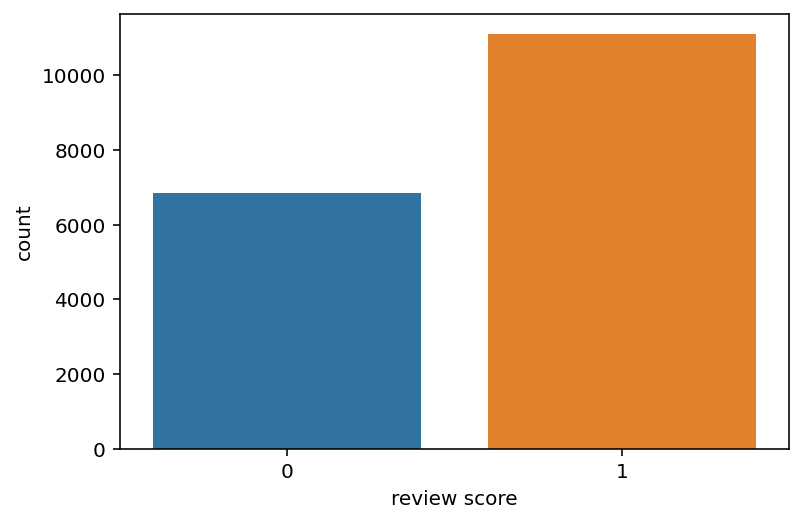

In [ ]:
sns.countplot(df.label)
plt.xlabel('review score');

In [ ]:
class_names = ['negative', 'positive']

## Data Preprocessing

In [ ]:
PRE_TRAINED_MODEL_NAME = 'dumitrescustefan/bert-base-romanian-cased-v1'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/397k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

The BERT model receives a fixed length of sentence as input.

For sentences that are shorter than this maximum length, we will have to add paddings (empty tokens) to the sentences to make up the length.

In the original implementation, the token **[PAD]** is used to represent paddings to the sentence.

In [ ]:
sample_txt = 'Cum ti-a fost vacanta? Minunata, am fost plecat 2 saptamana in Grecia.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence: {sample_txt}')
print(f'Tokens: {tokens}')
print(f'IDs: {token_ids}')

Sentence: Cum ti-a fost vacanta? Minunata, am fost plecat 2 saptamana in Grecia.
Tokens: ['Cum', 'ti', '-', 'a', 'fost', 'vacanta', '?', 'Minunat', '##a', ',', 'am', 'fost', 'plecat', '2', 'saptamana', 'in', 'Grecia', '.']
IDs: [1594, 2409, 17, 69, 487, 17290, 35, 39361, 207, 16, 474, 487, 3301, 22, 16358, 402, 6155, 18]


`[SEP]` - marker for ending of a sentence

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 3)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we are doing classification

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 2)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token.

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 1)

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # return PyTorch tensors
)

encoding.keys()

The token ids are now stored in a tensor and padded to a length of 32.



In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([    2,  1594,  2409,    17,    69,   487, 17290,    35, 39361,   207,
           16,   474,   487,  3301,    22, 16358,   402,  6155,    18,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

The attention mask has the same length. 

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens. 

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Cum',
 'ti',
 '-',
 'a',
 'fost',
 'vacanta',
 '?',
 'Minunat',
 '##a',
 ',',
 'am',
 'fost',
 'plecat',
 '2',
 'saptamana',
 'in',
 'Grecia',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

BERT works with fixed-length sequences. We are going to use a simple strategy to choose the max length. We will store the token length of each review. 

Most of the reviews seem to contain less than 128 tokens, but we will be on the safe side and choose a maximum length of 160. 

In [ ]:
MAX_LEN = 160

We have all building blocks required to create a PyTorch dataset. 

In [ ]:
class RoSentDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it will be easier to evaluate the predictions from our model.

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((16146, 3), (897, 3), (898, 3))

We also need to create a couple of data loaders. 

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = RoSentDataset(
    reviews=df.text.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Apply BERT

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/500M [00:00<?, ?B/s]

Some weights of the model checkpoint at dumitrescustefan/bert-base-romanian-cased-v1 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`. 

In [ ]:
bert_model.config.hidden_size

768

We can use all of this knowledge to create a classifier that uses the BERT model. 

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BERT model. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we are going to return the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

We wil move the example batch of our training data to the GPU. 

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x sequence length
print(attention_mask.shape) # batch size x sequence length

torch.Size([16, 160])
torch.Size([16, 160])


To get the predicted probabilities from our trained model, we will apply the softmax function to the outputs. 

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4254, 0.5746],
        [0.4856, 0.5144],
        [0.4862, 0.5138],
        [0.3682, 0.6318],
        [0.6270, 0.3730],
        [0.4104, 0.5896],
        [0.3554, 0.6446],
        [0.3654, 0.6346],
        [0.6034, 0.3966],
        [0.5728, 0.4272],
        [0.5278, 0.4722],
        [0.4791, 0.5209],
        [0.4615, 0.5385],
        [0.5258, 0.4742],
        [0.5126, 0.4874],
        [0.5768, 0.4232]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Training 

To reproduce the training procedure from the BERT paper, we will use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We will also use a linear scheduler with no warmup steps. 

In [ ]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(
    model, 
    data_loader, 
    loss_fn, 
    device, 
    n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We will also store the training history. 

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1} / {EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss: {train_loss} Train accuracy: {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Valid loss: {val_loss} Valid accuracy: {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1 / 5
----------
Train loss: 0.27476519928175475 Train accuracy: 0.8912424129815435
Valid loss: 0.24507021459571102 Valid accuracy: 0.9085841694537347

Epoch 2 / 5
----------
Train loss: 0.13279259651547787 Train accuracy: 0.9618481357611792
Valid loss: 0.3332732199699405 Valid accuracy: 0.9130434782608695

Epoch 3 / 5
----------
Train loss: 0.06783823286471911 Train accuracy: 0.9835872661959619
Valid loss: 0.43936058389647914 Valid accuracy: 0.9141583054626533

Epoch 4 / 5
----------
Train loss: 0.033519385726448137 Train accuracy: 0.9926297534993187
Valid loss: 0.4500759824050443 Valid accuracy: 0.9175027870680045

Epoch 5 / 5
----------
Train loss: 0.023497288723823173 Train accuracy: 0.9952310169701475
Valid loss: 0.49520166136892185 Valid accuracy: 0.9163879598662207



Note that we are storing the state of the best model, indicated by the highest validation accuracy.

## Plots

TypeError: ignored

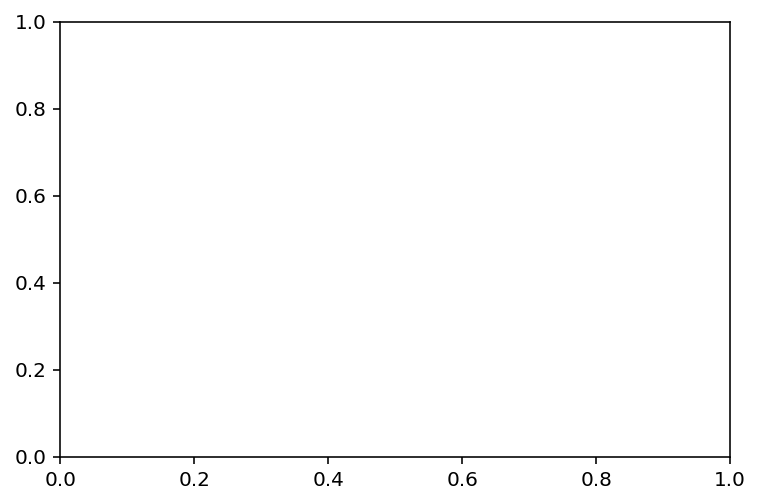

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation 

So how good is our model on predicting sentiment? We are going to start by calculating the accuracy on the test data. 

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9153674832962138

We will define a helper function to get the predictions from our model. 

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for data in data_loader:

      texts = data["review_text"]
      input_ids = data["input_ids"].to(device)
      attention_mask = data["attention_mask"].to(device)
      targets = data["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we are storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs).

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.88      0.91      0.89       344
    positive       0.94      0.92      0.93       554

    accuracy                           0.92       898
   macro avg       0.91      0.91      0.91       898
weighted avg       0.92      0.92      0.92       898



We will continue with the confusion matrix. 

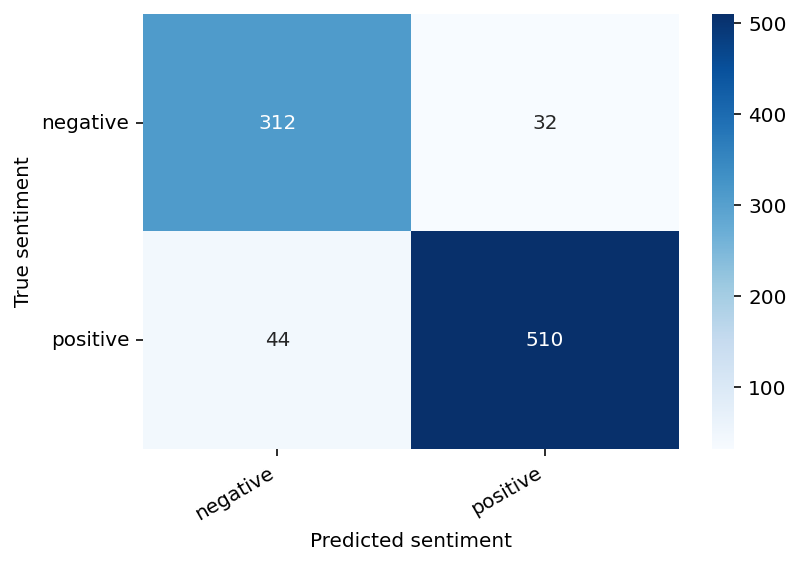

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

confusion_matrix = confusion_matrix(y_test, y_pred)
df_confusion_matrix = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
show_confusion_matrix(df_confusion_matrix)

That's a good overview of the performance of our model.

In [ ]:
index = 2

review_text = y_review_texts[index]
true_sentiment = y_test[index]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[index]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

filmul danez "slum slam slum" ma surprins sa fiu cel mai rau film pe
care l-am vazut pana acum. nu m-am gandit ca a fost posibil sa-mi
inregistrez lista de filme proaste, dar acest lucru merita aurul. nu
este amuzant. e rau, e rau filmat si povestea e rea. singurul lucru
pozitiv pe care il pot spune despre acest film este ca are trei fete
in el. cred cu adevarat ca acest film are potentialul de a bate
celalalt film danez "stjerner uden hjerner" ca cel mai rau film danez
realizat vreodata! si asta e cu adevarat ceva. felicitari in avans!

True sentiment: negative


Now we can look at the confidence of each sentiment of our model. 

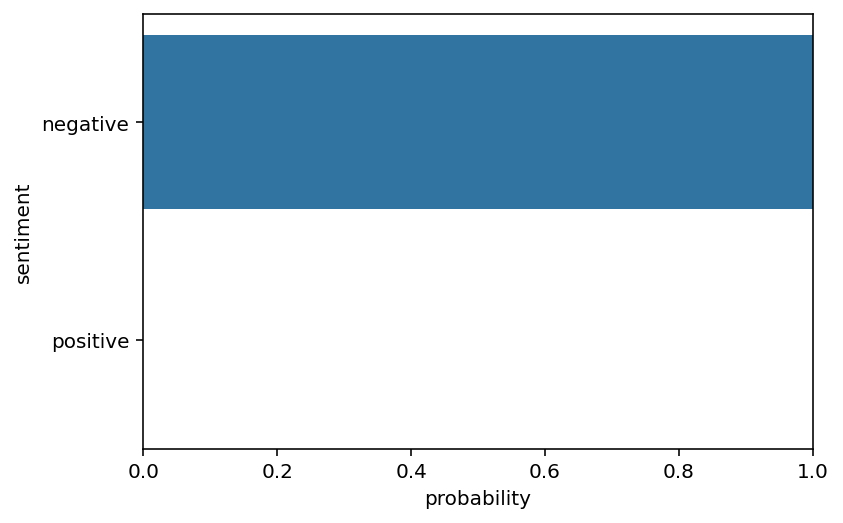

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

Let us use our model to predict the sentiment of some raw text. 

In [ ]:
review_text = "L-am vazut la o colega, foarte frumos, dar mie nu-mi vine."

We have to use the tokenizer to encode the text. 

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let us get the predictions from our model. 

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: L-am vazut la o colega, foarte frumos, dar mie nu-mi vine.
Sentiment  : negative


In [ ]:
review_text = "Am fost dezamagita de telefonul comandat de pe site-ul vostru!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Am fost dezamagita de telefonul comandat de pe site-ul vostru!
Sentiment  : negative
